# Linear Regression

In this notebook I will go through some of the theory behind Linear Regression as well as some common steps when modelling a Linear Regression with Python using scikit-learn, pandas and other modules.
<br>
***

#### Short Theory Summary:

Linear Regression is about modelling the (linear) relationship between an output variable (response) and *p* explanatory input variables (features). The linear model consists of parameters β for every input variable, a constant intercept β0 and errors *Ɛ*:<br> **Y = β0 + β1X1 + β2X2 + ··· + βpXp + Ɛ**
<br>β0: The model response when all other variables are 0: 
<br>Ɛ: The *error* Ɛ consists of all influences on Y which do not come from the input features. 
<br><br>The intercept and parameters are then fitted to the model by minimizing the error Ɛ (most commonly the **ordinary squared** Ɛ (**OLS**) between the real y and the prediction using different estimated intercepts and parameters.

#### Assumptions of a Linear Regression model/OLS

<ul>
    <li>Linearity</li>
    <li>No measurement errors</li>
    <li>Low multicollinearity</li>
    <li>Constant variance in errors</li>
    <li>Normally distributed errors</li>
</ul>

**Since this notebook is only about Linear Regression and some theory behind it, things like preparing the data or missing data will not be handled here.**

# Predicting Credit Rating using a Linear Regression

## The data:

A simulated set of data containing information on credit card customers provided for **"An Introduction for Statistical Learning" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani (https://www.statlearning.com/)**


#### Getting the data (shortened version and using only metric data)

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
os.chdir("C:/Users/Nicoo/Desktop/Exercise Projects/Python Data Mining")
credit = pd.read_csv("Credit.csv", index_col = 0)
credit = credit.drop(["Gender", "Student", "Married", "Ethnicity"], axis = "columns")
credit.head(2)

,Income,Limit,Rating,Cards,Age,Education,Balance
1,14.891,3606,283,2,34,11,333
2,106.025,6645,483,3,82,15,903


In [3]:
credit_y = credit["Rating"]
credit_x = credit.drop("Rating", axis ="columns")
column_list = list(credit_x.columns)

### Columns:
**- Income**: Income in USD (X1)
<br>**- Limit**: Credit limit (X2)
<br>**- Rating**: Credit Rating (Y)
<br>**- Cards**: Number of credit cards (X3)
<br>**- Age**: Age in years (X4)
<br>**- Education**: Number of years in education (X5)
<br>**- Balance**: Average Credit Card balance (X6)

### Simple Relationship between Credit Rating and Features through Scatterplots

Plotting the relationship between all features and the Credit Rating using my pre-written code:

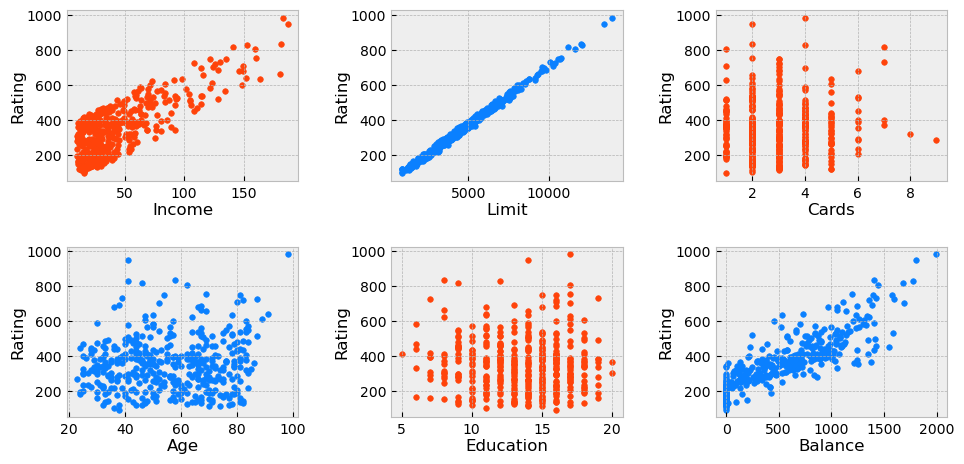

In [9]:
import ez_viz as ez
ez.plot_x_to_y(credit_x, credit_y, size = (10, 5), pad = 2, fontsize ="large")

## Approach:
<ul>
    <li><strong>Setting up full model</strong></li>
  <li><strong>In-sample testing</strong></li>
    <li><strong>Out-of-sample testing</strong></li>
    <li><strong>Checking the models assumptions</strong></li>
    <li><strong>Feature selection</strong></li>
</ul>

### Setting up full model 

**With sklearns Linear_model:**

In [7]:
from sklearn import linear_model
model1 = linear_model.LinearRegression()
model1.fit(credit_x, credit_y)
model1_pred = model1.predict(credit_x)
coefficents_and_intercept = pd.DataFrame(data = model1.coef_.reshape(1, 6), columns = column_list)
coefficents_and_intercept["Intercept"] = model1.intercept_ 

**Looking at the parameters and the intercept:**

In [8]:
coefficents_and_intercept.head()

,Income,Limit,Cards,Age,Education,Balance,Intercept
0,0.094816,0.06423,4.677061,0.008066,-0.230863,0.008181,31.052211


**Interpretation of parameters:**
<br>Model:
<br>*est.~Rating = 31.052 + 0.095 * Income + 0.064 * Limit + 4.677 * Cards + 0.008 * Age - 0.231 * Education + 0.008 * Balance*
<br>Regression parameters can be interpreted in a way, that if the value of a feature increases by 1 unit the estimated response increases (or decreases) by the parameter. For example, if a customers Credit Limit increases by 1, the estimated Credit Rating would increase by 0.064.

### In-sample testing
#### Coefficient of determination R2 (explained variance):
*R2 provides a measure of how well observed outcomes are replicated by the model, based on the proportion of total variation of outcomes explained by the model and usually lies between 0 and 1. An R2 of 1 indicates that the regression predictions perfectly fit the data.*

In [9]:
from sklearn.metrics import r2_score
r2_score(credit_y, model1_pred)

0.995736913480706

*Using the same set of data to train and test a model is generally not recommended since it risks overfitting the model to the existing data and make the model very unreliable with new data. To avoid these problems the data should be separated into test and training sets, this way the models accuracy can be examined with data that wasnt used to train it already.*

### Out-of-sample testing

Using an sklearn-function the data is now split into two groups, with the training data being 70% of the original data.

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(credit, test_size=0.3)
train_x = train.drop("Rating", axis = "columns")
test_x = test.drop("Rating", axis = "columns")
train_y = train["Rating"]
test_y = test["Rating"]

Fitting the new model, using only the training data:

In [11]:
model2 = linear_model.LinearRegression()
model2.fit(train_x, train_y)
model2_pred = model2.predict(test_x)

**R2 with out-of-sample data:**

In [12]:
r2_score(test_y, model2_pred)

0.9954958486315519

**Mean Squared Prediction Error (MSE):**

*The squared error between the predicted y values and the real test y:*

In [13]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y, model2_pred)

120.03148983709353

**K-fold Cross Validation:**

Splitting the data in K groups and fitting K models, with one group serving as the test data. Then calculate metrics of accuracy for every model, i.e. MSE:

In [14]:
from sklearn.model_selection import cross_val_score
cv_results = cross_val_score(model2, credit_x, credit_y, cv=5, scoring='neg_mean_squared_error')
np.mean(cv_results)

-105.39001697538508

### Checking the models assumptions

**Detecting Multicollinearity through Pearson Correlation:**

High correlation between two features can be problematic and should be avoided.

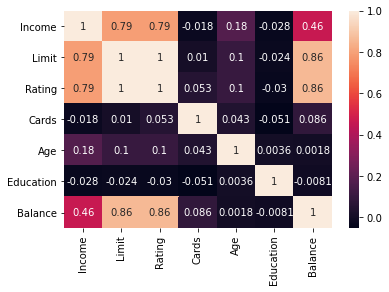

In [15]:
import seaborn as sn
corrMatrix = credit.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

- *Strong correlation between Limit and Balance and Limit and Income.*

**Constant variance in errors / residuals**

*Plotting errors against features and look for constant variance:*

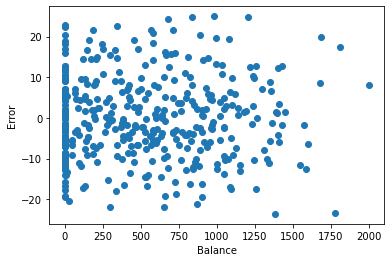

In [16]:
residuals = (credit_y - model1_pred)
plt.scatter(y = residuals, x = credit["Balance"], marker = "o")
plt.xlabel("Balance")
plt.ylabel("Error")
plt.show()

-  *No change in variane of errors for different Balance values.*

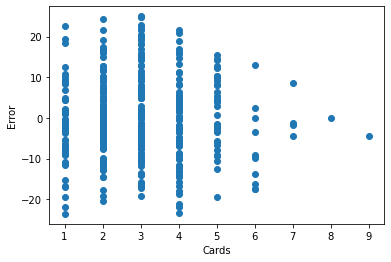

In [17]:
plt.scatter(y = residuals, x = credit["Cards"], marker = "o")
plt.xlabel("Cards")
plt.ylabel("Error")
plt.show()

- *Noticable trend with declining variance in errors for increasing number of cards.*

**Normally distributed errors**

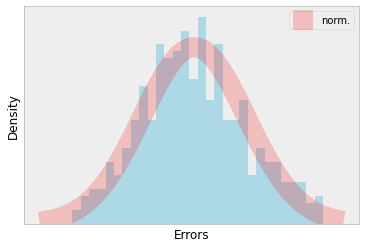

In [18]:
from scipy.stats import norm
x_axis = np.arange(-30, 30)
plt.style.use("bmh")
plt.hist(residuals, bins = 30, density = True, color = "lightblue")
plt.xlabel("Errors")
plt.ylabel("Density")
plt.plot(x_axis, norm.pdf(x_axis,np.mean(residuals),np.sqrt(np.var(residuals))), color = "red", solid_capstyle = 'butt', alpha = 0.2, linewidth = 20, label = "norm.")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.style.use("bmh")
plt.show()

- *The errors have a slight left screw but are approximately normally distributed.*

### Feature selection

#### Sequential Feature Selection:

Backward-SFS: Fitting the model with all features and then eliminate the "worst" features sequentially:

*Using the models R2 score to determine the best 70% of features:*

In [19]:
from sklearn.feature_selection import SequentialFeatureSelector
sfs = SequentialFeatureSelector(estimator = linear_model.LinearRegression(), n_features_to_select=0.7, scoring = "r2")
sfs.fit(credit_x, credit_y)
column_list_new = np.array(column_list)
column_list_r2 = column_list_new[sfs.get_support()]
column_list_r2

array(['Income', 'Limit', 'Cards', 'Education'], dtype='<U9')

- *Columns 'Age' and 'Balance' were dropped.*

*Using the models MSE score to determine the best 50% of features:*

In [20]:
from sklearn.feature_selection import SequentialFeatureSelector
sfs_2 = SequentialFeatureSelector(estimator = linear_model.LinearRegression(), n_features_to_select=0.5, scoring = "neg_mean_squared_error")
sfs_2.fit(credit_x, credit_y)
column_list_mse = column_list_new[sfs_2.get_support()]
column_list_mse

array(['Limit', 'Cards', 'Education'], dtype='<U9')

- Columns 'Age', 'Balance' and 'Income' were dropped

**Many different ways to determine which features are useful; some other sklearn methods are: *SelectKBest*, *SelectFromModel*, ...**